<a href="https://colab.research.google.com/github/MarekSroka/SDA_projekty/blob/main/Car%20Price%20prediction/project_cars_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

# Project description

The main objective of the project is **to predict the car price** so it's the machine learning regression problem.

Starter dataset contains the following features:

-Price (target variable)

-Levy -  tax (levy)

-Manufacturer - producer

-Model - model

-Prod. year - year of production

-Category - type of vehicle

-Leather interior 

-Fuel type 

-Engine volume

-Mileage

-Cylinders

-Gear box type

-Drive wheels

-Doors 

-Color 

-Airbags

# EDA, data cleaning and visualization

In this project target is variable $\it{Price}$.
Result of data cleaning and transformations will be stored in cars_mod data frame for safety and separation from the original data.

In [ ]:
cars_org=pd.read_csv('drive/MyDrive/ML_uczenie_nadzorowane_regresja/car_price.csv')
cars_org.reset_index(inplace=True)
cars_mod=pd.DataFrame()

First, we drop duplicates from the entire dataset

In [ ]:
cars_org.drop_duplicates(inplace=True)
print(cars_org.head(3))
cars_org.iloc[16983,:]

   index        ID  Price  Levy  ...   Doors             Wheel   Color Airbags
0      0  45654403  13328  1399  ...  04-May        Left wheel  Silver      12
1      1  44731507  16621  1018  ...  04-May        Left wheel   Black       8
2      2  45774419   8467     -  ...  04-May  Right-hand drive   Black       2

[3 rows x 19 columns]


index                     16983
ID                     45812886
Price                  26307500
Levy                          -
Manufacturer               OPEL
Model                     Combo
Prod. year                 1999
Category            Goods wagon
Leather interior             No
Fuel type                Diesel
Engine volume               1.7
Mileage                99999 km
Cylinders                   4.0
Gear box type            Manual
Drive wheels              Front
Doors                    02-Mar
Wheel                Left wheel
Color                      Blue
Airbags                       0
Name: 16983, dtype: object

ID Column doesn't have relevant impact on prediction accuracy, so it can be dropped

In [ ]:
cars_org.drop(['ID'], axis=1, inplace=True)

Replacing outliers by the average price of same cars year older and year younger.

In [ ]:
a=cars_org['Price'].loc[(cars_org['Manufacturer']=='OPEL')&(cars_org['Model']=='Combo')&(cars_org['Prod. year']==1998)]
b=cars_org['Price'].loc[(cars_org['Manufacturer']=='OPEL')&(cars_org['Model']=='Combo')&(cars_org['Prod. year']==2000)]
c=(a.iloc[0]+b.iloc[0])/2
z=cars_org.loc[(cars_org['Manufacturer']=='OPEL')&(cars_org['Model']=='Combo')&(cars_org['Prod. year']==1999)].index[0]
cars_org.iloc[z,1]=c

In [ ]:
cars_org.loc[(cars_org['Manufacturer']=='OPEL')&(cars_org['Model']=='Combo')&(cars_org['Prod. year']==1999)]

,index,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
16983,16983,5636,-,OPEL,Combo,1999,Goods wagon,No,Diesel,1.7,99999 km,4.0,Manual,Front,02-Mar,Left wheel,Blue,0


Due to reducing the number of outliers I've decided to reduce the age of cars to 40 yrs.
This is in line with domain - specific knowledge. Old cars are used be valued based on specialist inspection and number of sold/bought oldtimers are to small to put them together in the same mechanism of car pricing like popular younger cars.

In [ ]:
cars_org.loc[cars_org['Prod. year']<1982].count()
cars_org = cars_org.loc[cars_org['Prod. year']>=1982, :]

For similar reasons luxury cars can be excluded from data frame - limit 200.000$\$$

In [ ]:
cars_org.loc[cars_org['Price']>200000,:]

,index,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1225,1225,627220,-,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,Yes,Petrol,6.3 Turbo,0 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
2283,2283,219527,-,BENTLEY,Continental GT,2012,Coupe,Yes,Petrol,4.0 Turbo,55500 km,8.0,Tiptronic,4x4,02-Mar,Left wheel,Black,0
5008,5008,308906,1694,PORSCHE,911,2016,Coupe,Yes,Petrol,4,8690 km,6.0,Automatic,Rear,02-Mar,Left wheel,Black,12
5840,5840,254024,1292,MERCEDES-BENZ,GLE 400 A M G,2016,Jeep,Yes,Petrol,3.0 Turbo,73000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,12
7283,7283,228935,-,MERCEDES-BENZ,GLE 63 AMG,2018,Jeep,Yes,Petrol,5.5 Turbo,23000 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,16
7353,7353,216391,-,MERCEDES-BENZ,G 65 AMG G63 AMG,2013,Jeep,Yes,Petrol,5.5 Turbo,54000 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
7749,7749,288521,2269,BMW,M5 Машина в максимально,2018,Sedan,Yes,Petrol,4.4,13500 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
8541,8541,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
9367,9367,297930,-,MERCEDES-BENZ,AMG GT S,2015,Coupe,Yes,Petrol,4.0 Turbo,20000 km,8.0,Tiptronic,Rear,02-Mar,Left wheel,White,16
10759,10759,260296,-,LEXUS,LX 570,2018,Jeep,Yes,Petrol,5.7 Turbo,17700 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,10


In [ ]:
cars_org=cars_org.loc[cars_org['Price']<200000,:]

In [ ]:
cars_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19199 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             19199 non-null  int64  
 1   Price             19199 non-null  int64  
 2   Levy              19199 non-null  object 
 3   Manufacturer      19199 non-null  object 
 4   Model             19199 non-null  object 
 5   Prod. year        19199 non-null  int64  
 6   Category          19199 non-null  object 
 7   Leather interior  19199 non-null  object 
 8   Fuel type         19199 non-null  object 
 9   Engine volume     19199 non-null  object 
 10  Mileage           19199 non-null  object 
 11  Cylinders         19199 non-null  float64
 12  Gear box type     19199 non-null  object 
 13  Drive wheels      19199 non-null  object 
 14  Doors             19199 non-null  object 
 15  Wheel             19199 non-null  object 
 16  Color             19199 non-null  object

In data set, there are a few columns that should be numerical but they are objects.

In [ ]:
yr=2022 #actual year

In [ ]:
cars_org.columns

Index(['index', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

In [ ]:
cars_org['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo', '0', '20',
       '3.6 Turbo', '0.3', '3.7 Turbo', '5.9', '5.5 Turbo', '6.3 Turbo',
       '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo', '0.6 Turbo', '6.8',
       '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3', '4.5 Turbo',
       '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4', '3.9', '0.9',
       '

In car Engine volume column there is some additional information about engine, so this column was split into two and original one type switched into numerical

In [ ]:
cars_org['Engine volume']=cars_org['Engine volume'].str.replace(' ','')

In [ ]:
def trb(value):
    if value[-5:]=='Turbo':
        return 1
    else:
        return 0
cars_org['turbo']=cars_org['Engine volume'].apply(trb)

In [ ]:
cars_org['Engine volume']=cars_org['Engine volume'].str.replace('Turbo','')
cars_org['Engine volume']=cars_org['Engine volume'].astype('float')

Cars with engine volume = 0 was recognized as damaged and also excluded. Outlier was also recognized and fixed.

In [ ]:
cars_org.loc[cars_org['Engine volume']==0,:]

,index,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,turbo
2010,2010,53941,87,TESLA,Model X,2018,Sedan,Yes,Petrol,0.0,81907 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,0
3105,3105,2430,87,MERCEDES-BENZ,C 250,2013,Coupe,Yes,Petrol,0.0,121600 km,4.0,Automatic,Rear,04-May,Left wheel,White,12,0
3516,3516,27356,87,HYUNDAI,Elantra,2016,Sedan,Yes,LPG,0.0,65004 km,4.0,Automatic,Front,04-May,Left wheel,White,4,0
4814,4814,17663,87,TOYOTA,Aqua,2012,Hatchback,Yes,Petrol,0.0,118000 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4,0
7022,7022,17663,87,TOYOTA,Aqua,2012,Hatchback,Yes,Petrol,0.0,118000 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4,0
7685,7685,47076,87,SSANGYONG,REXTON,2016,Jeep,Yes,Diesel,0.0,73968 km,4.0,Automatic,Front,04-May,Left wheel,Black,4,0
10603,10603,12231,87,TOYOTA,Prius,2010,Hatchback,No,Hybrid,0.0,0 km,4.0,Automatic,Front,04-May,Left wheel,Golden,0,0
12917,12917,6,87,MERCEDES-BENZ,E 350,2016,Sedan,Yes,Petrol,0.0,33600 km,6.0,Automatic,Rear,04-May,Left wheel,White,12,0
14642,14642,3,87,PORSCHE,Panamera,2011,Sedan,Yes,Petrol,0.0,196800 km,6.0,Automatic,Rear,04-May,Left wheel,Black,12,0
17375,17375,78,87,MERCEDES-BENZ,CLS 550,2014,Sedan,Yes,Petrol,0.0,92800 km,8.0,Automatic,Rear,04-May,Left wheel,Black,12,0


In [ ]:
cars_org=cars_org.loc[cars_org['Engine volume']>0,:]
cars_org.loc[cars_org['Engine volume']==0,:]

,index,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,turbo


In [ ]:
def fix(no):
    if no==20:
        return 2
    else:
        return no
cars_org['Engine volume']=cars_org['Engine volume'].apply(fix)
cars_org['Engine volume']

0        3.5
1        3.0
2        1.3
3        2.5
4        1.3
        ... 
19232    2.0
19233    2.4
19234    2.0
19235    2.0
19236    2.4
Name: Engine volume, Length: 19189, dtype: float64

In [ ]:
cars_mod['Price']=cars_org['Price']
cars_mod['Mileage']=cars_org['Mileage'].str.replace('km','').astype('float')
cars_mod['car_age']=yr-cars_org['Prod. year']
cars_mod['Engine volume']=cars_org['Engine volume']
cars_mod['Turbo']=cars_org['turbo']
cars_mod['Cylinders']=cars_org['Cylinders']
cars_mod['Airbags']=cars_org['Airbags']
cars_mod

,Price,Mileage,car_age,Engine volume,Turbo,Cylinders,Airbags
0,13328,186005.0,12,3.5,0,6.0,12
1,16621,192000.0,11,3.0,0,6.0,8
2,8467,200000.0,16,1.3,0,4.0,2
3,3607,168966.0,11,2.5,0,4.0,0
4,11726,91901.0,8,1.3,0,4.0,4
...,...,...,...,...,...,...,...
19232,8467,300000.0,23,2.0,1,4.0,5
19233,15681,161600.0,11,2.4,0,4.0,8
19234,26108,116365.0,12,2.0,0,4.0,4
19235,5331,51258.0,15,2.0,0,4.0,4


Variable $\it{Levy}$ in original data set means kind of tax, so value "-" means tax-free, so missing values means 0. This column will be also transformed as float type.

In [ ]:
cars_mod['tax']=cars_org['Levy'].str.replace('-','0').astype('float')

At this level of preprocessing dataframe car_mod contains only numerical data.

In [ ]:
num_features=[ 'Mileage', 'car_age', 'Engine volume', 'Turbo', 'Cylinders',
       'Airbags', 'tax']
target='Price'

In [ ]:
value=[target]+num_features
corr_matrix=cars_mod[value].corr()
corr_matrix['Price']

Price            1.000000
Mileage         -0.015465
car_age         -0.311171
Engine volume    0.125265
Turbo            0.196394
Cylinders        0.090968
Airbags         -0.025556
tax              0.040584
Name: Price, dtype: float64

In [ ]:
cars_mod['cylvol']=cars_mod['Engine volume']/cars_mod['Cylinders']

In [ ]:
value=[target]+num_features+['cylvol']
corr_matrix=cars_mod[value].corr()
corr_matrix['Price']

Price            1.000000
Mileage         -0.015465
car_age         -0.311171
Engine volume    0.125265
Turbo            0.196394
Cylinders        0.090968
Airbags         -0.025556
tax              0.040584
cylvol           0.102336
Name: Price, dtype: float64

No need to include $\it{cylvol}$ variable. No increase of correlation with target observed.

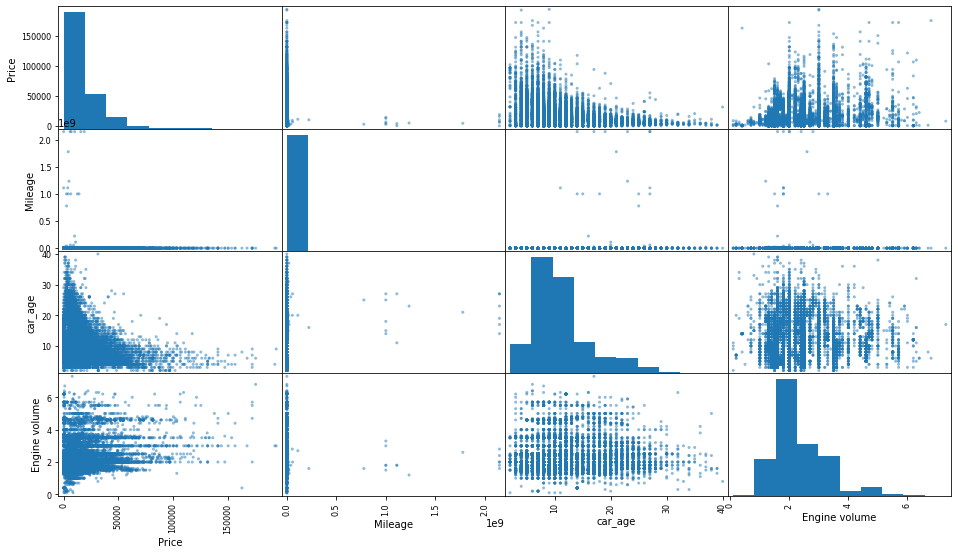

In [ ]:
scatter_matrix(cars_mod.iloc[:,0:4], figsize=(16,9))
plt.show()

In [ ]:
cars_mod.describe()

,Price,Mileage,car_age,Engine volume,Turbo,Cylinders,Airbags,tax,cylvol
count,19189.000000,1.918900e+04,19189.000000,19189.000000,19189.000000,19189.000000,19189.000000,19189.000000,19189.000000
mean,16986.917088,1.423955e+06,11.028037,2.306029,0.100057,4.580802,6.586065,633.400177,0.501142
std,17371.017582,4.592145e+07,5.372283,0.855150,0.300084,1.196548,4.315782,566.874427,0.133093
min,1.000000,0.000000e+00,2.000000,0.100000,0.000000,1.000000,0.000000,0.000000,0.033333
25%,5331.000000,7.033600e+04,7.000000,1.800000,0.000000,4.000000,4.000000,0.000000,0.416667
50%,13172.000000,1.261170e+05,10.000000,2.000000,0.000000,4.000000,6.000000,642.000000,0.500000
75%,22000.000000,1.890000e+05,13.000000,2.500000,0.000000,4.000000,12.000000,917.000000,0.583333
max,194438.000000,2.147484e+09,40.000000,7.300000,1.000000,16.000000,16.000000,11714.000000,6.300000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


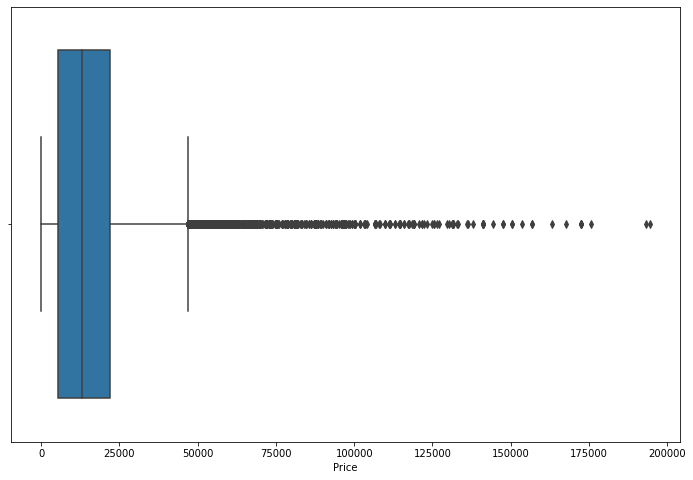

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


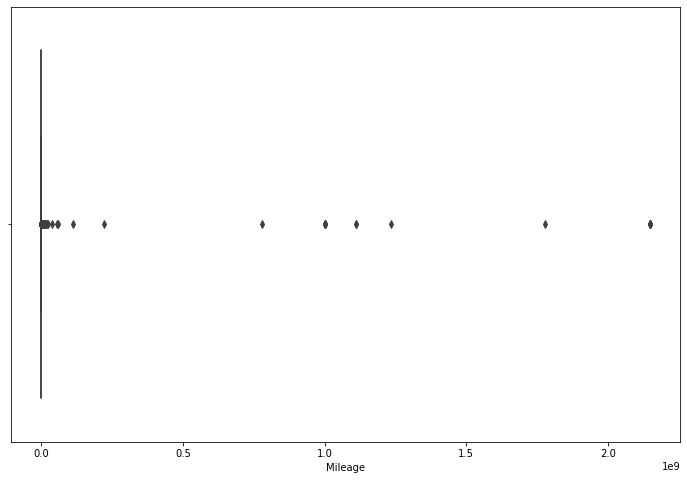

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


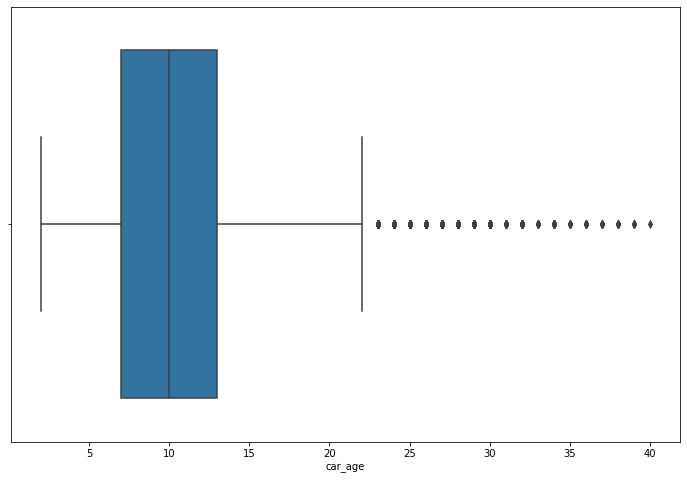

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


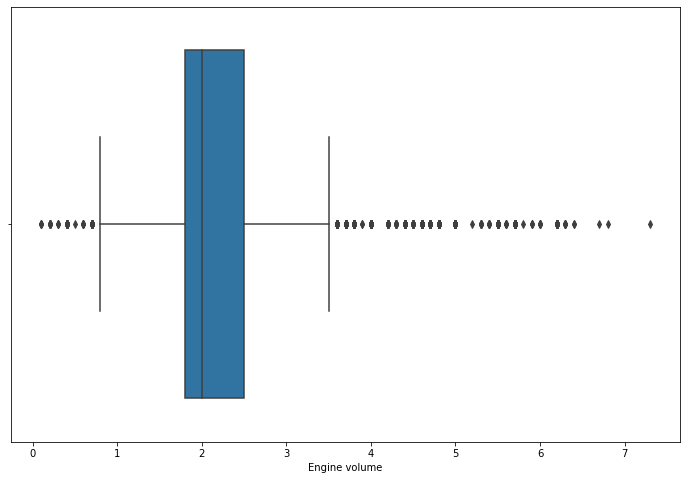

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


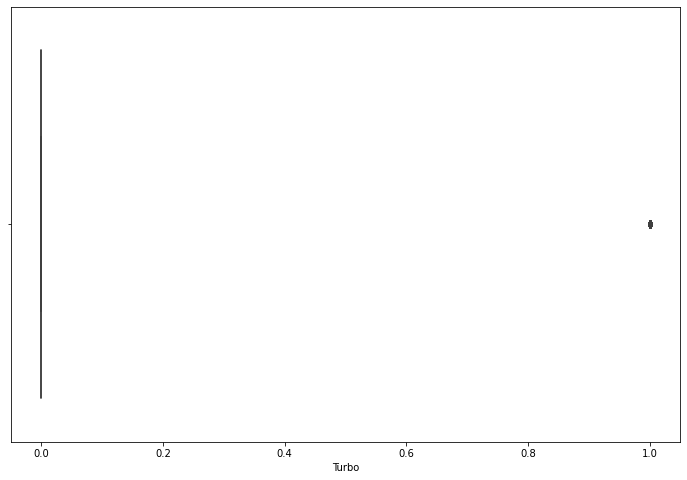

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


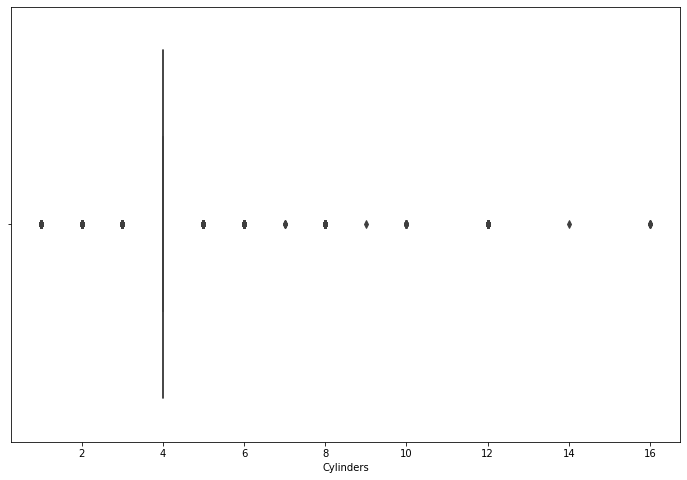

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


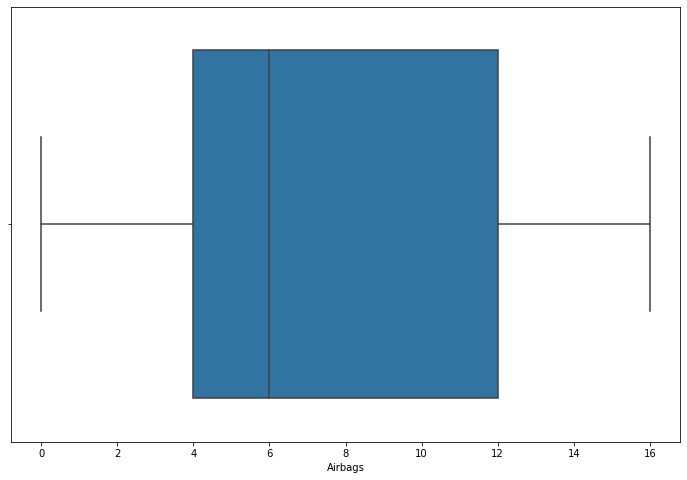

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


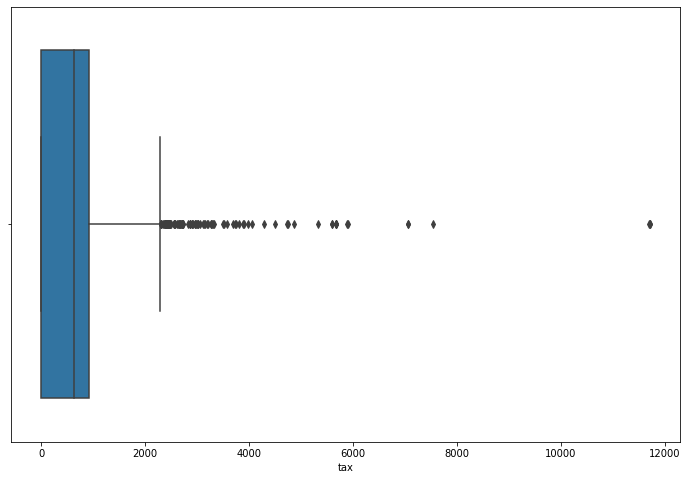

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


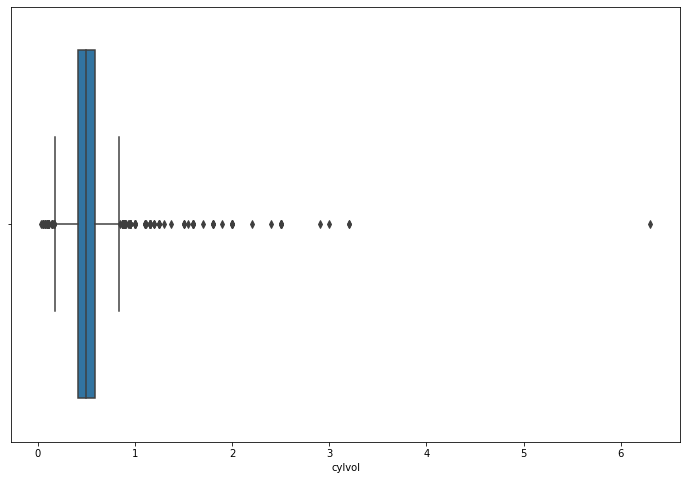

In [ ]:
for i in range (cars_mod.shape[1]):
    plt.figure(figsize=(12,8))
    sns.boxplot(cars_mod.iloc[:,i])
    plt.show()

In [ ]:
cars_mod

,Price,Mileage,car_age,Engine volume,Turbo,Cylinders,Airbags,tax,cylvol
0,13328,186005.0,12,3.5,0,6.0,12,1399.0,0.583333
1,16621,192000.0,11,3.0,0,6.0,8,1018.0,0.500000
2,8467,200000.0,16,1.3,0,4.0,2,0.0,0.325000
3,3607,168966.0,11,2.5,0,4.0,0,862.0,0.625000
4,11726,91901.0,8,1.3,0,4.0,4,446.0,0.325000
...,...,...,...,...,...,...,...,...,...
19232,8467,300000.0,23,2.0,1,4.0,5,0.0,0.500000
19233,15681,161600.0,11,2.4,0,4.0,8,831.0,0.600000
19234,26108,116365.0,12,2.0,0,4.0,4,836.0,0.500000
19235,5331,51258.0,15,2.0,0,4.0,4,1288.0,0.500000


In [ ]:
cars_org.columns

Index(['index', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'turbo'],
      dtype='object')

In [ ]:
or_encoder = OrdinalEncoder()
cat_features=['Manufacturer','Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']

In [ ]:
cars_mod[cat_features]=or_encoder.fit_transform(cars_org[cat_features])

In [ ]:
value=[target]+cat_features
corr_matrix=cars_mod[value].corr()
corr_matrix['Price']

Price               1.000000
Manufacturer       -0.078303
Leather interior    0.128272
Fuel type          -0.038688
Gear box type       0.122281
Drive wheels       -0.037206
Doors               0.025712
Wheel              -0.134782
Color              -0.015451
Name: Price, dtype: float64

# Modelling

# 1.Linear regression - *dummy* model

In [ ]:
features=num_features
data_set=cars_mod[num_features]
X=data_set
y=cars_mod[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60222)

In [ ]:
lin_reg_model=LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_predict_test=lin_reg_model.predict(X_test)

In [ ]:
err=np.sqrt(mean_squared_error(y_test, y_predict_test))
print(f'RMSE={err}')

RMSE=15945.23614863465


In [ ]:
features=num_features
data_set=cars_mod[num_features]
X=data_set
y=cars_mod[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60222)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15351, 7), (3838, 7), (15351,), (3838,))

In [ ]:
scaler=StandardScaler()

In [ ]:
X_train_mod=X_train[features]
X_test_mod=X_test[features]
y_train_mod=y_train
y_test_mod=y_test
X_train_mod=scaler.fit_transform(X_train_mod)
X_test_mod=scaler.transform(X_test_mod)
lin_reg_model.fit(X_train_mod, y_train_mod)

LinearRegression()

In [ ]:
y_test_mod.shape,X_test_mod.shape

((3838,), (3838, 7))

In [ ]:
y_predict_test_2=lin_reg_model.predict(X_test_mod)
y_predict_test_2

array([12228.5045714 , 20240.7611251 , 20255.58380457, ...,
       20646.71743002, 21524.00314222, 16856.27395202])

In [ ]:
err=np.sqrt(mean_squared_error(y_test_mod, y_predict_test_2))
print(f'RMSE={err}')

RMSE=15945.236148634653


# 2. Decision Tree Regresssor - basic version

In [ ]:
tree_model=DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree=tree_model.predict(X_test)
err2=np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f'RMSE={err2}')

RMSE=12751.164692657801


In [ ]:
features=num_features
data_set=cars_mod[num_features]
X=data_set
y=cars_mod[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60222)

In [ ]:
n_max_depth=np.linspace(4,20,17)
n_min_samples_split=np.linspace(2,50,49).astype('int').astype('int')

In [ ]:
modelling = DecisionTreeRegressor()

params = {'max_depth': list(n_max_depth),
          'min_samples_split':list(n_min_samples_split)}

tree_gridsearch = GridSearchCV(modelling, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=1,
                                                n_jobs=-1)

tree_gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 833 candidates, totalling 8330 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                                       12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0,
                                       19.0, 20.0],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print('\nBest hyperparameter:', tree_gridsearch.best_params_)


Best hyperparameter: {'max_depth': 13.0, 'min_samples_split': 33}


In [ ]:
tree_model=DecisionTreeRegressor(max_depth=13, min_samples_split= 33)
tree_model.fit(X_train, y_train)
y_pred_tree=tree_model.predict(X_test)
err2=np.round(np.sqrt(mean_squared_error(y_test, y_pred_tree)),2)
print(f'RMSE={err2}')

RMSE=10607.49


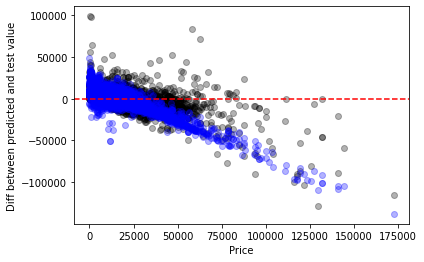

In [ ]:
#plot
errors1 = y_predict_test - y_test
errors2 = y_pred_tree - y_test
plt.scatter(y_test, errors2, color='k',alpha =0.3)
plt.scatter(y_test, errors1, color='b',alpha=0.3)
plt.ylabel('Differences between predicted and test value')
plt.xlabel('Price')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# 3. Decision Tree Regresssor with the same model, optimal parameters, included categorical data applied as One Hot encoder and log scaler to minimize skewness and transformation of data

Pipeline creation - repeated $X$, $y$ data declaration and splits base on same random state split to make sure that operation on right data is secured.

In [ ]:
features=num_features+cat_features
data_set=cars_mod[features]
X=data_set
y=cars_mod[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60222)

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('log_transformer', PowerTransformer()),
    ('standardscaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('OHE', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', DecisionTreeRegressor())])

In [ ]:
params = {'regressor__max_depth': list(n_max_depth),
          'regressor__min_samples_split':list(n_min_samples_split)}
tree_gridsearch = GridSearchCV(final_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=1,
                                                n_jobs=-1)

tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch.best_params_)
final_model=tree_gridsearch.best_estimator_

Fitting 10 folds for each of 833 candidates, totalling 8330 fits

Best hyperparameter: {'regressor__max_depth': 19.0, 'regressor__min_samples_split': 32}


In [ ]:
new_predictions = final_model.predict(X_test)
new_mse2 = mean_squared_error(y_test, new_predictions)
print(f'RMSE: {np.sqrt(new_mse2)}')

RMSE: 10174.263182134331


In [ ]:
cars_mod['Price'].mean()

16986.91708791495

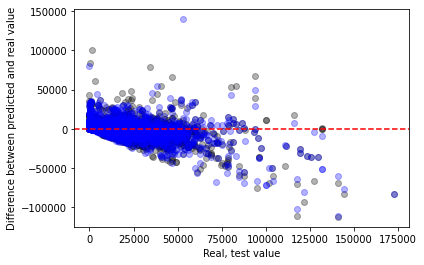

In [ ]:
errors1 = y_predict_test - y_test
errors2 = y_pred_tree - y_test
errors3 = new_predictions - y_test
plt.scatter(y_test, errors2, color='k',alpha =0.3)

plt.scatter(y_test, errors3, color='b',alpha=0.3)
plt.ylabel('Difference between predicted and real value')
plt.xlabel('Real, test value')
plt.axhline(0, color='red', linestyle='--')
plt.show()

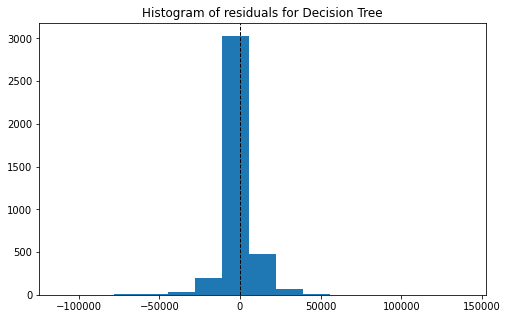

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(errors3, bins=15)
plt.axvline(errors3.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of residuals for Decision Tree')

plt.show()

In [ ]:
n=10
x_ran=[]
i=0
while i<n:
    x=random.randint(0, X_test.shape[0])
    x_ran.append(x)
    i=i+1

In [ ]:
x_ran

[3233, 399, 1028, 3728, 2629, 1499, 1703, 259, 707, 3701]

In [ ]:
r_pred=[]
r_test=[]
r_err=[]
for i in x_ran:
    a=X_test.iloc[i,:]
    new_pred=final_model.predict(X_test)[i]
    r_pred.append(new_pred)
    r_test.append(y_test.iloc[i])
    r_err.append(y_test.iloc[i]-new_pred)

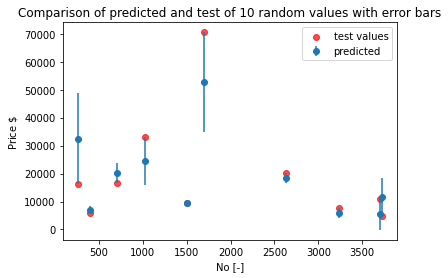

In [ ]:
plt.errorbar(x_ran,r_pred, yerr=r_err,fmt='o', label='predicted')
plt.scatter(x_ran,r_test, color='red', label='test values', alpha=0.7)
plt.legend()
plt.title('Comparison of predicted and test of 10 random values with error bars')
plt.ylabel('Price $\$$')
plt.xlabel('No [-]')
plt.show()


Summary:
1. Linear regression model was used as "dummy model" and base result for future comparison. Received value was:


In [ ]:
print(f'RMSE for LinearRegression: {np.round(err,2)}')

RMSE for LinearRegression: 15945.24


2. DecisionTreeRegressor allowed (standard scaler) with grid search of optimal received parameters allowed to decrease this value to:


In [ ]:
print(f'RMSE for DecisionTreeRegressor:  {np.round(err2,2)}')

RMSE for DecisionTreeRegressor:  10607.49


3. Last approach with the same model, optimal parameters, included categorical data applied as One Hot encoder and log scaler to minimize skewness and transformation of data to make them close to a Gaussian distribution allowed 
reduce RMSE to:

In [ ]:
print(f'Final RMSE for DecisionTreeRegressor: {np.round(np.sqrt(new_mse2))}')

Final RMSE for DecisionTreeRegressor: 10174.0
